## Desafío:

Mejora el desempeño de nuestra regressión Lasso **SOLO usando diferentes pasos de ingenería de variables!!**.

El desempeño de nuestro modelo, como puedes ver en este notebook, es el siguiente:
- rmse en el set de prueba: 44798.497576784845
- r2 en el set de prueba: 0.7079639526659389

Para mejorar el desempeño de nuestro modelo debes lograr un r2 en el set de prueba mayor que 0.71 y un rmse en el set de prueba menor que 44798.


### Condiciones:

- No PUEDES cambiar los parámetros del modelo Lasso
- DEBES usar las mismas semillas para la clase Lasso y el método train_test_split como mostramos en el notebook (no cambies los valores del parámetro random_state)
- DEBES usar TODAS las variables del conjunto de datos (a excepción de Id)- NO PUEDES seleccionar variables


### Si mejoras el desempeño de nuestro modelo:

Crea una solicitud de extracción -'pull request'- con tu notebook en este repositorio de github:
https://github.com/solegalli/udemy-ivml-desafio

Recuerda que necesitas primero bifurcar -'fork'- el repositorio, luego cargar tu notebook ganador a tu repositorio y finalmente crear una solicitudes de extracción (PR 'pull request') a nuestro repositorio. Luego revisaremos y fusionaremos tu solicitud, la cual aparecerá en nuestro repo y estará disponible para todos los estudiantes de este curso. De esta forma, otros estudiantes podrán aprender de tu creatividad e ingenio al transformar las variables de este conjunto de datos!

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# para la ingeniería de variables
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Cargar los datos

In [2]:
# cargar los datos

data = pd.read_csv('../houseprice.csv')

In [3]:
# crea una lista de los tipos de variables

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('Hay {} variables continuas '.format(len(numerical)))
print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables temporales'.format(len(year_vars)))
print('Hay {} variables categóricas'.format(len(categorical)))

Hay 18 variables continuas 
Hay 14 variables discretas
Hay 4 variables temporales
Hay 43 variables categóricas


### Separar sets de entrenamiento y prueba 

In [4]:
# IMPORTANTE: 
# manten el random_state igual a zero para poder reproducir los resultados

# Separemos los datos en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculemos el tiempo transcurrido

def elapsed_years(df, var):
    # captura la diferencia entre la variable año var
    # y el año de construcción de la casa
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# elimina la variable YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# captura el nombre de las columnas para usarlas más
# adelante en el notebook
final_columns = X_train.columns

## Pipeline de Ingeniería de Variables

In [8]:
# Vamos a manipular las variables discretas como
# si fueran categóricas 
# para lograrlo usando Feature-engine
# necesitamos modificar el tipo de variables a
# una tipo 'object'

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [9]:
house_pipe = Pipeline([

    # imputación de dato ausentes - sección 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # codificación de variables categóricas - sección 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),

    # discretiazación + codificación - sección 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical)),

    # escalamiento de variables - sección 10
    ('scaler', StandardScaler()),

    # regresión
    ('lasso', Lasso(random_state=0))
])

In [10]:
# ajustemos el pipeline - conjunto de pasos de 
# para el pre-procesamiento y modelamiento

house_pipe.fit(X_train, y_train)

# obtengamos las predicciones
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\categorical_encoders.py:785: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn("The number of unique categories for variable {} is less than that indicated in "
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\categorical_encoders.py:785: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn("The number of unique categories for variable {} is less than that indicated in "
C:\Users\Sole\Documents\Repositories\envs\feml\lib\site-packages\feature_engine\categorical_encoders.py:785: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent

In [11]:
# revisemos desempeño del modelo:

print('mse entrenamiento: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('rmse entrenamiento: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('r2 entrenamiento: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('mse prueba: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('rmse prueba: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('r2 prueba: {}'.format(r2_score(y_test, X_test_preds)))

mse entrenamiento: 1035269885.2749027
rmse entrenamiento: 32175.610099497768
r2 entrenamiento: 0.834193183650799

mse prueba: 2006905385.1371982
rmse prueba: 44798.49757678485
r2 prueba: 0.7079639526659388


Text(0, 0.5, 'Predicciones de precio de las casas')

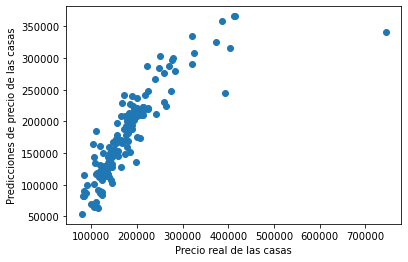

In [12]:
# grafiquemos las predicciones vs. los valores reales

plt.scatter(y_test,X_test_preds)
plt.xlabel('Precio real de las casas')
plt.ylabel('Predicciones de precio de las casas')

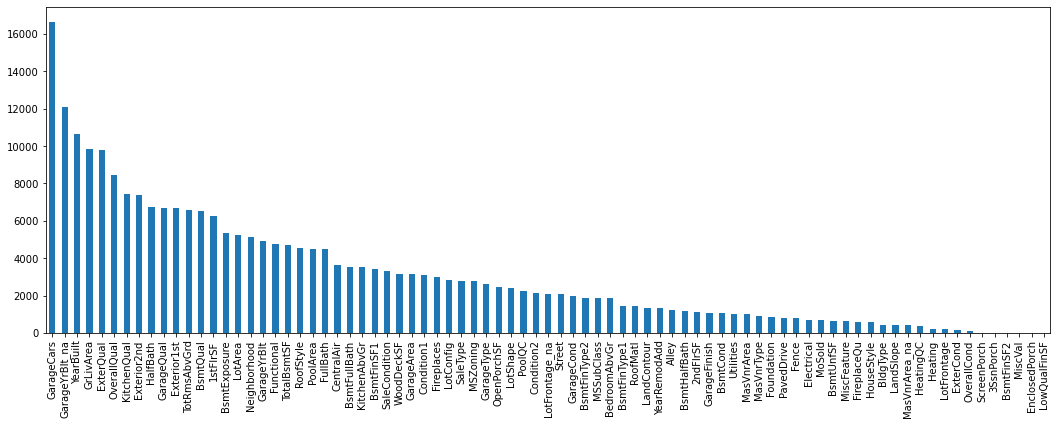

In [13]:
# exploremos la importancia de las variables
# en este caso importancia es el valor 
# absoluto del coeficiente asignado 
# por Lasso 

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))